In [2]:
# Path & Libraries

import sys 
import os 
import warnings

sys.path.append(os.path.abspath('dss'))
warnings.filterwarnings('ignore')

from src.dss_irrigation.mamdani.dss_package import *
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from ctgan import CTGAN
import skfuzzy as fuzz
from deap import algorithms, base, creator, tools
from skfuzzy import control as ctrl

random.seed(0)

file_path = '../data/val_data.xlsx'
val_data = pd.read_excel(file_path)
discrete_columns = [
    'Decision',
]

ctgan = CTGAN(verbose=True, epochs=100)
ctgan.fit(val_data, discrete_columns)

synthetic_data = ctgan.sample(10000)
synthetic_data.to_csv('synthetic_data.csv', index=False)

numerical_columns = val_data.select_dtypes(include=np.number).columns
categorical_column = "Decision"

input_variables = {
    'Last Avg Tensiometer': (50, 650),
    'Predicted Avg Tensiometer': (50, 650),
    'Predicted Rain Amount': (0, 40),
    'Predicted Max Temperature': (5, 40)
}

output_variable = {
    'Decision': ['Not Recommended', 'Half Turn', 'Single Turn', 'Double Turn']
}

for column, (min_val, max_val) in input_variables.items():
    synthetic_data[column] = np.clip(synthetic_data[column], min_val, max_val)

Gen. (0.59) | Discrim. (0.06): 100%|██████████| 100/100 [00:03<00:00, 29.49it/s]


In [3]:
print("Statistiche descrittive del dataset originale:")
print(val_data.describe())
print("\nStatistiche descrittive del dataset sintetico:")
print(synthetic_data.describe())

Statistiche descrittive del dataset originale:
       Last Avg Tensiometer  Predicted Avg Tensiometer  Predicted Rain Amount  \
count             66.000000                  66.000000              66.000000   
mean             343.924242                 380.454545               3.075758   
std              125.023605                 113.082432               5.638632   
min               62.000000                 101.000000               0.000000   
25%              280.000000                 349.250000               0.000000   
50%              349.500000                 381.500000               0.000000   
75%              420.000000                 460.000000               5.000000   
max              644.000000                 641.000000              20.000000   

       Predicted Max Temperature  
count                  66.000000  
mean                   28.712121  
std                     3.785662  
min                    22.000000  
25%                    25.000000  
50%          

In [4]:
print("Originale:")
print(val_data["Decision"].value_counts(normalize=True))
print("Sintetico:")
print(synthetic_data["Decision"].value_counts(normalize=True))

Originale:
Decision
Not Recommended    0.681818
Half Turn          0.136364
Single Turn        0.136364
Double Turn        0.045455
Name: proportion, dtype: float64
Sintetico:
Decision
Not Recommended    0.3693
Single Turn        0.2542
Half Turn          0.2279
Double Turn        0.1486
Name: proportion, dtype: float64


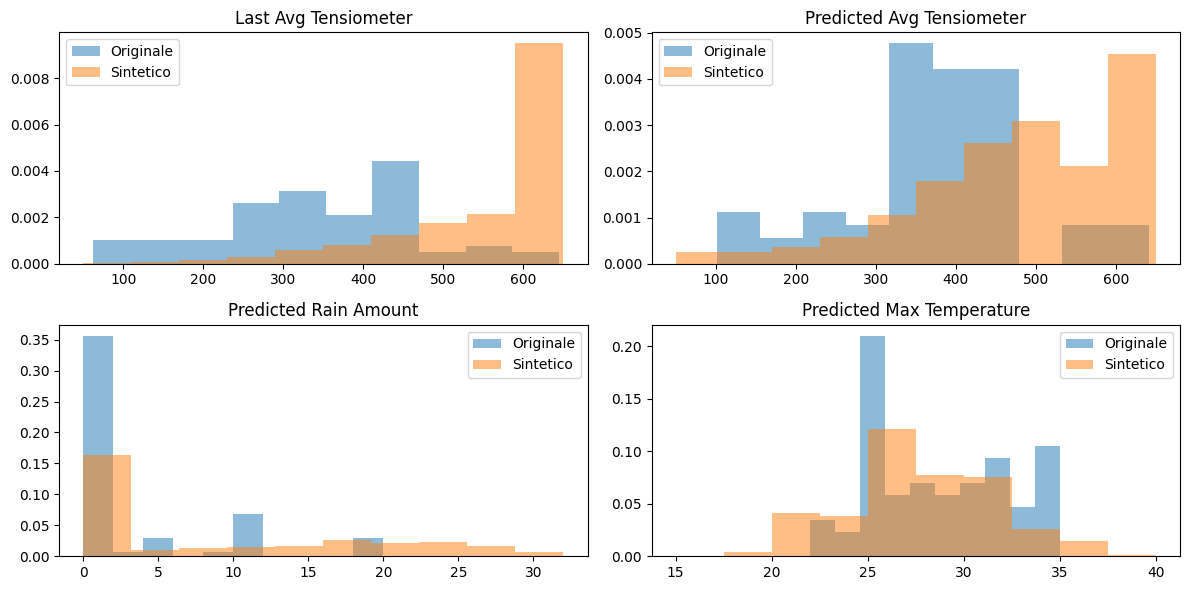

In [5]:
# Confronto delle Distribuzioni Univariate (per variabili numeriche)

plt.figure(figsize=(12, 6))
for column in val_data.select_dtypes(include=np.number).columns:
    plt.subplot(2, len(val_data.select_dtypes(include=np.number).columns)//2, 
                list(val_data.select_dtypes(include=np.number).columns).index(column)+1)
    plt.hist(val_data[column], alpha=0.5, label='Originale', density=True)
    plt.hist(synthetic_data[column], alpha=0.5, label='Sintetico', density=True)
    plt.title(column)
    plt.legend()
plt.tight_layout()
plt.show()

In [6]:
agg_stats_original = val_data.groupby(categorical_column).agg(['mean', 'std'])
agg_stats_synthetic = synthetic_data.groupby(categorical_column).agg(['mean', 'std'])

print("\nStatistiche aggregate condizionali nel dataset originale:")
print(agg_stats_original)

print("\nStatistiche aggregate condizionali nel dataset sintetico:")
print(agg_stats_synthetic)


Statistiche aggregate condizionali nel dataset originale:
                Last Avg Tensiometer             Predicted Avg Tensiometer  \
                                mean         std                      mean   
Decision                                                                     
Double Turn               532.666667   98.571463                561.666667   
Half Turn                 375.333333   48.849258                437.222222   
Not Recommended           310.355556  123.528273                333.422222   
Single Turn               417.444444  106.638538                498.444444   

                           Predicted Rain Amount            \
                       std                  mean       std   
Decision                                                     
Double Turn      88.556950              0.000000  0.000000   
Half Turn        59.438577              3.333333  5.000000   
Not Recommended  94.683081              3.844444  6.263007   
Single Turn      71.09

In [7]:
# Data Loading & Processing

excel_file = '../data/dss_rules.xlsx'

fuzzy_rules_sheet = 'Rules'
crispy_values_sheet = 'Crispy Values'
fuzzy_values_sheet = 'Fuzzy Values'

rules_df = pd.read_excel(excel_file, sheet_name=fuzzy_rules_sheet)
rules_df = rules_df.iloc[:, :-1].rename(columns=lambda x: x.lower().replace(' ', '_'))
crispy_df = pd.read_excel(excel_file, sheet_name=crispy_values_sheet)
fuzzy_df = pd.read_excel(excel_file, sheet_name=fuzzy_values_sheet)
nice_feature_names = fuzzy_df.columns[1:].tolist()
fuzzy_df = fuzzy_df.iloc[:, 1:].rename(columns=lambda x: x.lower().replace(' ', '_'))

# Feature Names
input_variables = rules_df.columns[:-1].tolist()
output_variable = rules_df.columns[-1]

# Category Names
crispy_input = crispy_df.iloc[:, 0].dropna().values
crispy_output = crispy_df.iloc[:, 1].dropna().values

# Summary Values
fuzzy_values = fuzzy_df.values
fuzzy_min = fuzzy_values[0]
fuzzy_max = fuzzy_values[1]
num_classes = fuzzy_values[2].astype(int)


# Fuzzy Input Variables (Universe & Membership Function)

feature_dict = {}
universe_dict = {}

for var, min_val, max_val, num_class in zip(input_variables, fuzzy_min[:-1], fuzzy_max[:-1], num_classes[:-1]):
    feature_dict[var] = {}
    fraction_range = (max_val - min_val) / (num_class - 1)
    universe = np.arange(min_val - 2 * fraction_range, max_val + 2 * fraction_range + 1, 1)
    universe_dict[var] = universe
    for i, term_name in enumerate(crispy_input):
        if i == 0:
            feature_dict[var] = ctrl.Antecedent(universe, var)
            term_range = [min_val - 2 * fraction_range, min_val - 2 * fraction_range, min_val, min_val + fraction_range]
            feature_dict[var][term_name] = fuzz.trapmf(feature_dict[var].universe, term_range)
        elif i == num_class - 1:
            term_range = [max_val - fraction_range, max_val, max_val + 2 * fraction_range, max_val + 2 * fraction_range]
            feature_dict[var][term_name] = fuzz.trapmf(feature_dict[var].universe, term_range)
        else:
            term_range = [min_val + (i - 1) * fraction_range, min_val + i * fraction_range, min_val + (i + 1) * fraction_range]
            feature_dict[var][term_name] = fuzz.trimf(feature_dict[var].universe, term_range)


# Fuzzy Output Variable

var = output_variable
min_val = fuzzy_min[-1]
max_val = fuzzy_max[-1]
num_class = num_classes[-1]

feature_dict[var] = {}
fraction_range = (max_val - min_val) / (num_class - 1)
universe = np.arange(min_val - 2 * fraction_range, max_val + 2 * fraction_range + 1, 1)
universe_dict[var] = universe
for i, term_name in enumerate(crispy_output):
    if i == 0:
        feature_dict[var] = ctrl.Consequent(universe, var)
        term_range = [min_val - 2 * fraction_range, min_val - 2 * fraction_range, min_val, min_val + fraction_range]
        feature_dict[var][term_name] = fuzz.trapmf(feature_dict[var].universe, term_range)
    elif i == num_class - 1:
        term_range = [max_val - fraction_range, max_val, max_val + 2 * fraction_range, max_val + 2 * fraction_range]
        feature_dict[var][term_name] = fuzz.trapmf(feature_dict[var].universe, term_range)
    else:
        term_range = [min_val + (i - 1) * fraction_range, min_val + i * fraction_range, min_val + (i + 1) * fraction_range]
        feature_dict[var][term_name] = fuzz.trimf(feature_dict[var].universe, term_range)
        

# Fuzzy Rules

rule_dict = {}

n_rules = rules_df.shape[0]
n_features = rules_df.shape[1]

for i in range(n_rules):
    term_input = None
    term_output = None
    
    for j in range(n_features):

        if j == 0:
            term_input = feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]

        elif j == n_features-1:
            term_output = feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]

        elif not pd.isna(rules_df.iloc[i, j]):
            term_input = term_input & feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]

        else:
            continue

    rule_dict[i] = ctrl.Rule(antecedent = term_input, consequent = term_output)


# Control System Creation & Simulation

rule_vector = []

for i in range(len(rule_dict)):
    rule_vector.append(rule_dict[i])

dss_ctrl = ctrl.ControlSystem(rule_vector)
dss = ctrl.ControlSystemSimulation(dss_ctrl, flush_after_run=100 * 100 + 1)        

ValueError: Membership function 'nan' does not exist for Consequent predicted_max_temperature.
Available options: 'Not Recommended'; 'Half Turn'; 'Single Turn', or 'Double Turn'.

In [1]:
def make_fuzzy_predictions(input_data, dss, input_variables, output_variable):
    for column, (min_val, max_val) in input_variables.items():
        input_data[column] = np.clip(input_data[column], min_val, max_val)
    
    # Make predictions
    predictions = []
    for _, row in input_data.iterrows():
        for var in row.index:
            dss.input[var] = row[var]
        dss.compute()
        predictions.append(dss.output[output_variable])
    
    return pd.Series(predictions, name=output_variable)

# Define input variables with their ranges
input_variables = {
    'Current Avg Tensiometer': (50, 650),
    'Predicted Avg Tensiometer': (50, 650),
    'Predicted Rain Amount': (0, 40),
    'Predicted Max Temperature': (5, 40)
}

In [2]:
# Extract the first three rows of synthetic_data and remove the last column
input_data = synthetic_data.iloc[:3, :-1]
input_data.columns = input_data.columns.str.replace(' ', '_').str.lower()

input_data

NameError: name 'synthetic_data' is not defined

In [9]:
predi = make_fuzzy_predictions(input_data, dss, input_variables, 'Irrigation - Decision')